# Ribosome Profile Simulator

This script is used to create simulated ribosome profiles from scratch. The simulation works by drawing a set of elongation rates from a gamma distribution and then plugging those rates into the equations from the inhomogenous l-TASEP model in order to create estimations of ribosome density across the transcript. These distributions of ribosome density are then randomly sampled from in order to create the equivalent of 

### Step 1
Activate the Plastid conda environment and open up a Jupyter Lab session (alternatively, a python file can be run in this python environment)

### Step 2
Load in all of the necessary Python packages.

In [1]:
import numpy as np
import pandas as pd
import Simulation_utils as sim
import dif_utils as dif
import matplotlib.pyplot as plt
%matplotlib inline
from multiprocess import Pool
from tqdm import tqdm

In [2]:
image_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'

### Step 3
Use a for-loop to run the simulate_profile() function multiple times to create a set of simulated count arrays. The parameters used to generate these simulations can be altered in several different ways depending on how we want to simulate the mutation. In this example, we are simulating 1 random pause per 100 codons with a pause strength that is equal to a reduction in elongation rate of 85%. The initiation rate is kept constant at 0.01 and the termination rate is kept very high at 2 in order to prevent termination limitation from occurring. Save our simulated count arrays along with the flux and phase of the simulations into lists. 

In [3]:
data_control = []
j_control = []
phase_control = []
min_control = []
data_mutant = []
j_mutant = []
phase_mutant = []
min_mutant = []
for i in range(24):
    length = np.random.randint(100,2500)
    alpha = 0.01
    x = sim.simulate_profile(mean_lambda = 4, sd = 3, length = length, a= alpha, B = 2, min_read_density = 0.5, 
                            pause_density = 0.02, pause_str = 0.16, pause_area = 0.4,
                            a_frac = 1, elon_frac = 1, return_min_lam = True)
    data_control.append(x[0])
    j_control.append(x[1])
    phase_control.append(x[2])
    min_control.append(x[3])
    data_mutant.append(x[4])
    j_mutant.append(x[5])
    phase_mutant.append(x[6])
    min_mutant.append(x[7])

### Step 4
Smooth out the simulated count arrays using Loess smoothing and calculate the cumulative read distributions. This step can take some time so it is recommended to use the multiprocess.Pool() function to complete this using multiple cores. 

In [4]:
max_pool = 8

with Pool(max_pool) as p:
    pool_control, pool_mutant = list(
            p.imap(dif.get_smoothed_vector,
                   data_control)
        ), list(
            p.imap(dif.get_smoothed_vector,
                    data_mutant)
        )

## Determine KS statistic for all transcripts

### Step 5
For each gene in your simulated mutant and control samples, calculate the KS-statistic as the maximum distance between their cumulative distributions and then save this KS-statistic as a list. 

In [6]:
# Define your lists
ks_list = []
len_list = []
id_list = []

# Calculate the KS statistic for each example and fill up our lists.
for tr_m, tr_c, index in zip(data_mutant, data_control, list(range(len(data_mutant)))):
    position = np.array(list(range(len(tr_m))))
    smoothed_vec_m, cumul_m = pool_mutant[index]
    smoothed_vec_c, cumul_c = pool_control[index]
    ks = max(abs(cumul_m - cumul_c))
    ks_list.append(ks)
    len_list.append(len(tr_m))
    id_list.append(index)

### Step 6
Combine the lists for the gene IDs, gene lengths, fluxes, phases, and KS statistics into a pandas dataframe using the pd.DataFrame, list() & zip() functions. 

In [7]:
# reorganizing the lists into a dataframe. 
df_b = pd.DataFrame(list(zip(ks_list, j_control, j_mutant, phase_control, phase_mutant, min_control, min_mutant, len_list, id_list)))
df_b.columns = ["ks_stat","J_control", "J_mutant","phase_control", "phase_mutant","min_control", "min_mutant", "gene_length", "id"]

### Step 7
sort your newly made dataframe from the lowest KS statistic to the highest KS statistic using \newline \verb|df.sorted()|

In [8]:
# Sort all of the values by the KS statistic. 
df_sorted = df_b.sort_values(by = "ks_stat")

### Step 8
Create a list called colours which will contain a colour based on the phase that was used for the mutant in the simulation. Save this list as a new column on our dataframe. 

In [9]:
# Create new columns which record a different colour, size, and point shape depending on the phase of the simulated sample. 
colours = []
sizes = []
shapes = []
for i in df_sorted.phase_mutant:
    if i == "MC":
        colours.append("magenta")
        sizes.append(100)
        shapes.append('None')
    elif i == "LD":
        colours.append("g")
        sizes.append(12)
        shapes.append("g")
    elif i == "HD":
        colours.append("b")
        sizes.append(50)
        shapes.append("none")
df_sorted["colours"] = colours
df_sorted["sizes"] = sizes
df_sorted["shapes"] = shapes

### Step 9
Use a scatterplot to view the KS statistic from all of the control-mutant comparisons to see if the mutants that were simulated as being elongation limited (MC) have higher KS statistics than the other comparisons. The points of this scatterplot will be colour coded based on the colours column of your dataframe. You should be able to see a clear separation between the samples where the mutation induced elongation limitation and the samples where where the mutation only induced some strong pauses. 

In [10]:
df_sorted.to_csv(image_path + "Simulated_plot_data.csv", index = False)

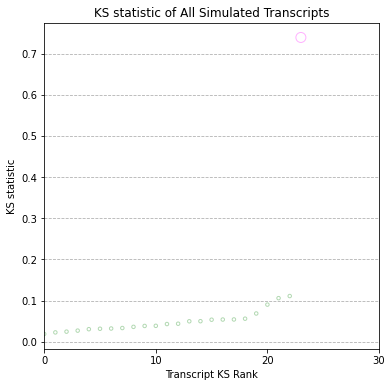

In [12]:
# Plot the KS values for each gene from lowest to highest. 
plt.figure(figsize = (6,6))
plt.scatter(list(range(len(df_sorted.ks_stat))), df_sorted.ks_stat, s = df_sorted.sizes, alpha = 0.3, facecolors = "none", edgecolors= df_sorted.colours)
plt.ylabel("KS statistic")
plt.xlabel("Transcript KS Rank")
plt.title("KS statistic of All Simulated Transcripts")
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.xlim(0,30)
plt.locator_params(axis="x", nbins=4)
plt.savefig(image_path + 'colour_coded_simulation.pdf')

## Choose a simulated gene of interest and observe the smooth and unsmooth array.

In [13]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_gene = "Simulated"
my_vec_mutant = data_mutant[0]
my_vec_control = data_control[0]

In [15]:
smoothed_vec_m, cumul_m = dif.get_smoothed_vector(my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = dif.get_smoothed_vector(my_vec_control+0.00000000001)

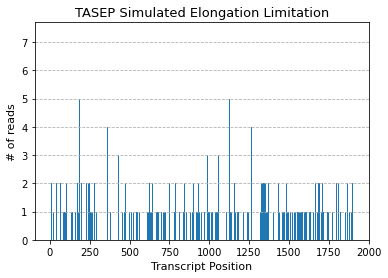

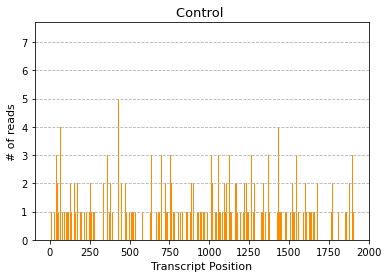

In [16]:
maxi = max([max(my_vec_mutant), max(my_vec_control)])

plt.bar(list(range(len(my_vec_mutant))),my_vec_mutant, width = 1.4)
plt.ylim([0,maxi*1.1])
plt.ylabel("# of reads", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("TASEP Simulated Elongation Limitation", fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_mutant_array.pdf')
plt.show()
plt.bar(list(range(len(my_vec_mutant))), my_vec_control, color = "darkorange", width = 1.4)
plt.ylim([0,maxi*1.1])
plt.ylabel("# of reads", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Control ", fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_control_array.pdf')

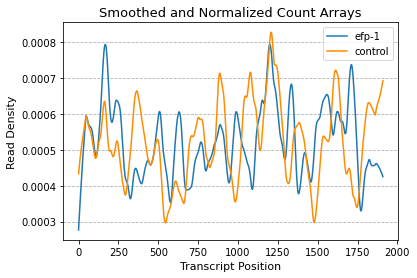

In [17]:
plt.plot(smoothed_vec_m, label = "efp-1")
plt.plot(smoothed_vec_c, label = "control", color = "darkorange")
plt.ylabel("Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Smoothed and Normalized Count Arrays", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")

In [18]:
ks = max(abs(cumul_m - cumul_c))

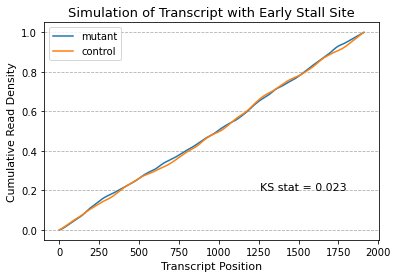

In [19]:
plt.plot(cumul_m, label = "mutant")
plt.plot(cumul_c, label = "control")
plt.text(len(cumul_m)*0.66, 0.2, "KS stat = " + str(round(ks,3)), fontsize = 11)
plt.ylabel("Cumulative Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Simulation of Transcript with Early Stall Site", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + 'Early_stall_site_cumulative.pdf')